# Model Interpretability

Often times when modeling we are asked the question -- How does the model work?  Why should we trust this model?  My response as a data scientist is usually "because we have rigorously proved model performance on a holdout testset with splits that are realistic to the real world". Oftentimes that is not enough to convince domain experts.

[LIME](https://homes.cs.washington.edu/~marcotcr/blog/lime/) is a tool which can help with this problem.  It uses local perturbations of featurespace to determine feature importance.  

![Selection_110.png](assets/lime_dog.png)

So if this tool can work in human understandable ways for images can it work on molecules?  In this tutorial I will show how to use LIME for model interpretability for any of our fixed-length featurization models.

## Making of the Model

The first thing we have to do is train a model.  Here we are going to train a toxicity model using Circular fingerprints

In [1]:
# Imaging imports to get pictures in the notebook
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D


import numpy as np
import deepchem as dc
from deepchem.molnet import load_tox21

# Only for debug!
np.random.seed(123)

# Load Tox21 dataset
n_features = 1024
tox21_tasks, tox21_datasets, transformers = load_tox21()
train_dataset, valid_dataset, test_dataset = tox21_datasets

# Fit models
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

nb_epoch = 10
model = dc.models.tensorgraph.fcnet.MultiTaskClassifier(
    len(tox21_tasks),
    train_dataset.get_data_shape()[0])

# Fit trained model
model.fit(train_dataset, nb_epoch=nb_epoch)
model.save()

print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

/home/leswing/miniconda3/envs/deepchem/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/leswing/Documents/deepchem/deepchem/models/tensorgraph/models/graph_models.py:1159: FutureWarning: GraphConvTensorGraph is deprecated and has been renamed to GraphConvModel and will be removed in DeepChem 3.0.
  FutureWarning)
/home/leswing/Documents/deepchem/deepchem/models/tensorgraph/models/graph_models.py:1170: FutureWarning: WeaveTensorGraph is deprecated and has been renamed to WeaveModel and will be removed in DeepChem 3.0.
  FutureWarning)


Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.
Evaluating model
computed_metrics: [0.9884486369100711, 0.9961494460500963, 0.9611122443486858, 0.9809094436045968, 0.9038691630558049, 0.9821596344228158, 0.9917931281413461, 0.910652841589047, 0.9862105294293689, 0.9707485731138213, 0.9467374907501964, 0.976972646417184]
computed_metrics: [0.6629891653886113, 0.7842261904761905, 0.8405998270604833, 0.7616293848500255, 0.6438409090909091, 0.7341869247108803, 0.7079439252336448, 0.8349186218558442, 0.7771132564162939, 0.7163115785688601, 0.8608110373901172, 0.7636089577950043]
Train scores
{'mean-roc_auc_score': 0.9663136481527529}
Validation scores
{'mean-roc_auc_score': 0.757348314903072}


## Using LIME

So LIME as is can work on any problem with a fixed size input vector.  It works by computing probability distributions for the individual features and covariance between the features.

We are going to create an explainer for our data

In [2]:
from lime import lime_tabular
feature_names = ["fp_%s"  % x for x in range(1024)]
explainer = lime_tabular.LimeTabularExplainer(train_dataset.X, 
                                              feature_names=feature_names, 
                                              categorical_features=feature_names,
                                              class_names=['not toxic', 'toxic'], 
                                              discretize_continuous=True)

/home/leswing/miniconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


We are going to attempt to explain why the model predicts a molecule to be toxic for NR-AR
The specific assay details can be found [here](https://pubchem.ncbi.nlm.nih.gov/bioassay/743040)

In [3]:
# We need a function which takes a 2d numpy array (samples, features) and returns predictions (samples,)
def eval_model(my_model, transformers):
    def eval_closure(x):
        ds = dc.data.NumpyDataset(x, None, None, None)
        # The 0th task is NR-AR
        predictions = model.predict_proba(ds)[:,0]
        return predictions
    return eval_closure
model_fn = eval_model(model, transformers)

41


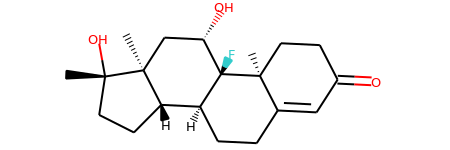

In [4]:
# We want to investigate a toxic compound
active_id = np.where(test_dataset.y[:,0]==1)[0][0]
print(active_id)
Chem.MolFromSmiles(test_dataset.ids[active_id])

In [5]:
# this returns an Lime Explainer class
# The explainer contains details for why the model behaved the way it did
exp = explainer.explain_instance(test_dataset.X[active_id], model_fn, num_features=5, top_labels=1)

In [6]:
# If we are in an ipython notebook it can show it to us
exp.show_in_notebook(show_table=True, show_all=False)

![explanation output](assets/lime_why_toxic.png)

So the model believes that fingerprint 118, 519 and 301 highly contribute to the molecule's toxicity.  We can reverse our the hash function and look at the fragments that activated those fingerprints for this molecule.

In [7]:
from rdkit import Chem

def fp_mol(mol, fp_length=1024):
    """
    returns: dict of <int:list of string>
        dictionary mapping fingerprint index
        to list of smile string that activated that fingerprint
    """
    d = {}
    feat = dc.feat.CircularFingerprint(sparse=True, smiles=True, size=1024)
    retval = feat._featurize(mol)
    for k, v in retval.items():
        index = k % 1024
        if index not in d:
            d[index] = set()
        d[index].add(v['smiles'])
    return d
# What fragments activated what fingerprints in our active molecule?
my_fp = fp_mol(Chem.MolFromSmiles(test_dataset.ids[active_id]))

# We can calculate which fragments activate all fingerprint
# indexes throughout our entire training set
all_train_fps = {}
X = train_dataset.X
ids = train_dataset.ids
for i in range(len(X)):
    d = fp_mol(Chem.MolFromSmiles(ids[i]))
    for k, v in d.items():
        if k not in all_train_fps:
            all_train_fps[k] = set()
        all_train_fps[k].update(v)

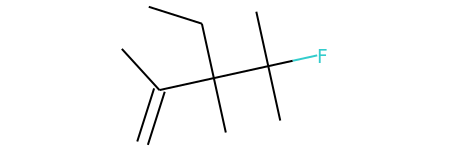

In [8]:
# We can visualize which fingerprints our model declared toxic for the
# active molecule we are investigating
Chem.MolFromSmiles(list(my_fp[118])[0])

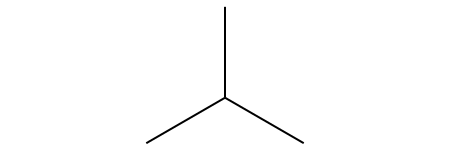

In [9]:
Chem.MolFromSmiles(list(my_fp[519])[0])

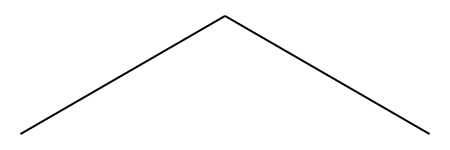

In [10]:
Chem.MolFromSmiles(list(my_fp[301])[0])

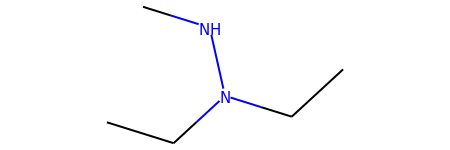

In [11]:
# We can also see what fragments are missing by investigating the training set 
# According to our explanation having one of these fragments would make our molecule more
# likely to be toxic
Chem.MolFromSmiles(list(all_train_fps[381])[0])

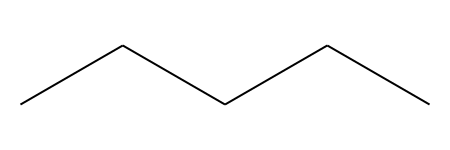

In [17]:
Chem.MolFromSmiles(list(all_train_fps[381])[1])

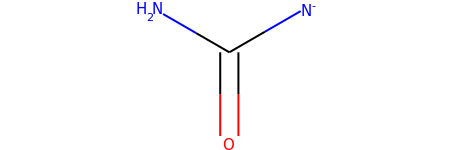

In [13]:
Chem.MolFromSmiles(list(all_train_fps[381])[4])

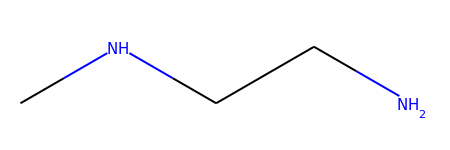

In [14]:
Chem.MolFromSmiles(list(all_train_fps[875])[0])

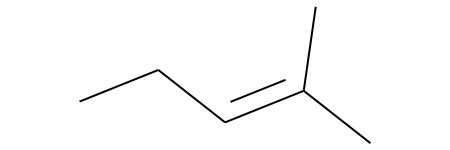

In [15]:
Chem.MolFromSmiles(list(all_train_fps[875])[2])

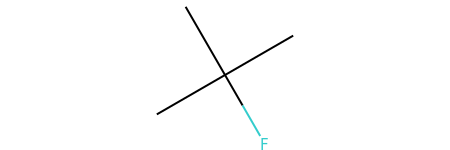

In [16]:
Chem.MolFromSmiles(list(all_train_fps[875])[4])

Using LIME on fragment based models can give you intuition over which fragments are contributing to your response variable in a linear fashion.